<a href="https://colab.research.google.com/github/Yasmine-ChemP/GMCtraining/blob/main/CP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import string
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('complaints.csv', engine='python', encoding='utf-8', error_bad_lines=False)

In [ ]:
data = data[['Product','Consumer complaint narrative']]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74263 entries, 0 to 74262
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       74263 non-null  object
 1   Consumer complaint narrative  26255 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
print(data["Product"].unique())

['Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Checking or savings account' 'Mortgage'
 'Credit card or prepaid card' 'Vehicle loan or lease' 'Student loan'
 'Payday loan, title loan, or personal loan'
 'Money transfer, virtual currency, or money service' 'Consumer Loan'
 'Bank account or service' 'Credit reporting']


In [ ]:
data=data.dropna().reset_index(drop=True)

In [ ]:
data.head()

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",This consumer reporting agency as defined by l...
1,Checking or savings account,I set up a recurring scheduled payment on my c...
2,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX, I went into online banking to s..."
3,"Credit reporting, credit repair services, or o...",ATTN Fraud Department : Remove fraudulent acco...
4,Debt collection,Was not aware of the XXXX XXXX that was placed...


In [ ]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    15666
Debt collection                                                                  3666
Credit card or prepaid card                                                      1983
Checking or savings account                                                      1663
Mortgage                                                                         1408
Money transfer, virtual currency, or money service                                748
Vehicle loan or lease                                                             469
Student loan                                                                      339
Payday loan, title loan, or personal loan                                         312
Consumer Loan                                                                       1
Name: Product, dtype: int64

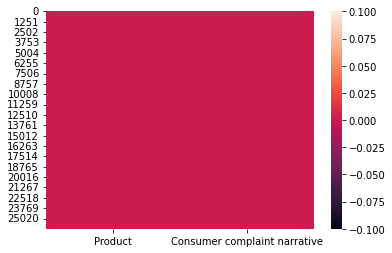

In [ ]:
sns.heatmap(data.isnull())

In [ ]:
# We will group some product types 
data.loc[data['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
data.loc[data['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
data.loc[data['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
data.loc[data['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'

In [ ]:
# In the code below you should add : Prepaid card, Consumer Loan & Bank account or service to "Other financial service"
#data.loc[data['Product']=='Other financial service', 'Product']= 'Prepaid card, Consumer Loan & Bank account, or service'
data.loc[data['Product'] == 'Other financial service', 'Product'] = 'Prepaid card, Consumer Loan, Bank account or service'
# CODE HERE

# We will not consider other financial service
# Code Here
data = data[data.Product != 'Other financial service']

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",This consumer reporting agency as defined by l...
1,Checking or savings account,I set up a recurring scheduled payment on my c...
2,"Credit reporting, credit repair services, or o...","On XX/XX/XXXX, I went into online banking to s..."
3,"Credit reporting, credit repair services, or o...",ATTN Fraud Department : Remove fraudulent acco...
4,Debt collection,Was not aware of the XXXX XXXX that was placed...
...,...,...
26250,"Credit reporting, credit repair services, or o...",Trans Union is incorrectly reporting an errone...
26251,"Credit reporting, credit repair services, or o...",The creditor XXXX ( account # XXXX ) committed...
26252,"Credit reporting, credit repair services, or o...",I am requesting that my credit report dispute ...
26253,Debt collection,I saw on my credit report I have an account wi...


In [ ]:
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    15666
Debt collection                                                                  3666
Credit card or prepaid card                                                      1983
Checking or savings account                                                      1663
Mortgage                                                                         1408
Money transfer, virtual currency, or money service                                748
Vehicle loan or lease                                                             469
Student loan                                                                      339
Payday loan, title loan, or personal loan                                         312
Consumer Loan                                                                       1
Name: Product, dtype: int64

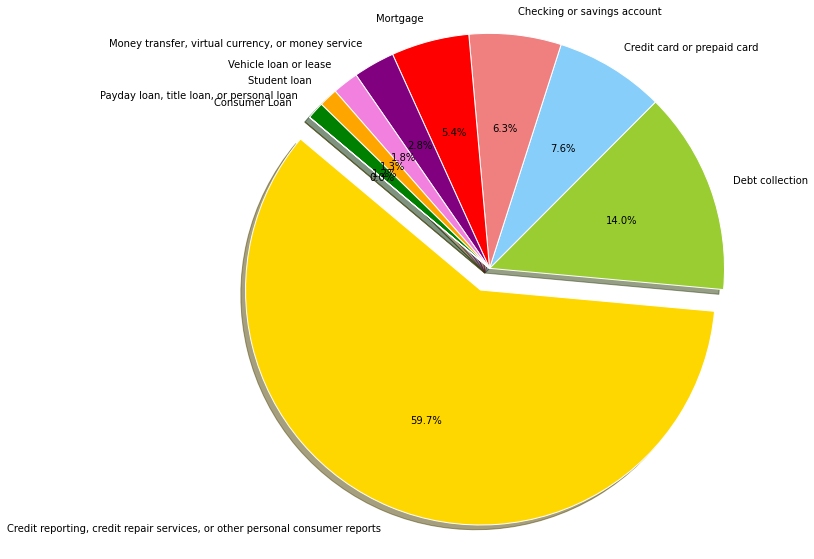

In [ ]:
# Data to plot
labels = list(data.Product.value_counts().index)
sizes = list(data.Product.value_counts().values)
colors = ['gold','yellowgreen', 'lightskyblue', 'lightcoral', 'red', 'purple', '#f280de', 'orange', 'green']
explode = (0.1, 0, 0, 0,0,0,0,0,0,0)  # explode 1st slice

# Plot
plt.figure(figsize=(10,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140, wedgeprops={"edgecolor":"white"})
plt.axis('equal')
plt.show()

In [ ]:
def complaint_product(indx,data):
  complaint = data['Consumer complaint narrative'][indx]
  product = data['Product'][indx]
  print(complaint)
  print('------------------------------')
  print("Product : ",product)

In [ ]:
complaint_product(238, data)

Hi I am submitting this XXXX XXXX without any influence and this is not a third party. TransUnion has low and unfair credit number for me in their report. I have complained. The problem has not been resolved. my fico has me at a credit score over XXXXtransunion has me at a score around XXXX. That is a huge difference. transunion paints me as a XXXX. my fico say I have good credit. What the heck is going on here. i have almost no debt and my identity was stolen causing my score to drop n i made this clear for 60 days straight with transunion i spoke to a representative agent name XXXX and XXXX and XXXX from the fraud department I prefer to speak to a us rept but they refused they had me on mute for 4 hours which was hurtful I have a perfect repayment record. I have very low credit utilization. I have three negative credit items outstanding debt now. I have modest but ok income. Social Security. Something is wrong with Transunion. I do not understand why they are abusing consumers .This 

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, remove stop words and Xs.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [ ]:
# Code Here
data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(clean_text) # apply clean_text function 

In [ ]:
data

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",consumer reporting agency defined law violated...
1,Checking or savings account,set recurring scheduled payment checking accou...
2,"Credit reporting, credit repair services, or o...",went online banking submit payment capital one...
3,"Credit reporting, credit repair services, or o...",attn fraud department remove fraudulent accoun...
4,Debt collection,aware placed credit report
...,...,...
26250,"Credit reporting, credit repair services, or o...",trans union incorrectly reporting erroneous ch...
26251,"Credit reporting, credit repair services, or o...",creditor account committed improper reporting ...
26252,"Credit reporting, credit repair services, or o...",requesting credit report dispute reviewed atte...
26253,Debt collection,saw credit report account past due reported co...


In [ ]:
# After cleaning
complaint_product(238, data)

hi submitting without influence third party transunion low unfair credit number report complained problem resolved fico credit score transunion score around huge difference transunion paints fico say good credit heck going almost debt identity stolen causing score drop n made clear days straight transunion spoke representative agent name fraud department prefer speak us rept refused mute hours hurtful perfect repayment record low credit utilization three negative credit items outstanding debt modest ok income social security something wrong transunion understand abusing consumers fist step towards attempting resolution kept lying telling disputed n reporting keep reporting inaccurate information without authorization refused unable verify n remove inquiries n record calls n admitted police report n ftc affidavit attempting contact transunion times transunion abusive company supposed protecting consumers need reigned causing severe stopping getting job offer n im n cant provide year old

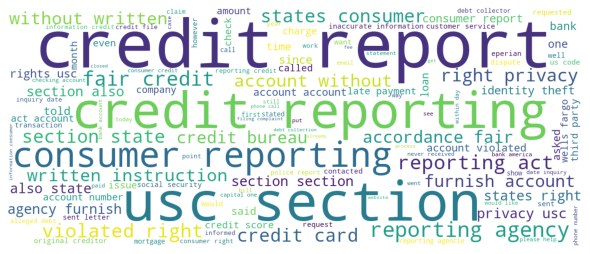

In [ ]:
text = " ".join(complaint for complaint in data["Consumer complaint narrative"])
# Generate a word cloud image

wordcloud = WordCloud(width = 1200, height = 500, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(text) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
number_words = [len(complaints.split(' ')) for complaints in data["Consumer complaint narrative"]]

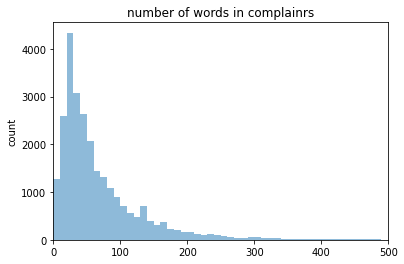

In [ ]:
# fixed bin size
bins = np.arange(-0, 3000, 10) # fixed bin size

plt.xlim([0, 500])

plt.hist(number_words, bins=bins, alpha=0.5)
plt.title('number of words in complainrs')
plt.ylabel('count')

plt.show()

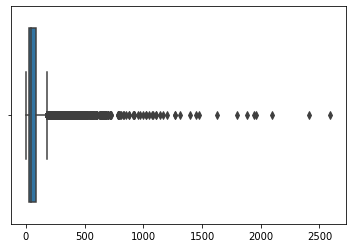

In [ ]:
sns.boxplot(number_words)

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 25905 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(data['Consumer complaint narrative'].values)#list of integers
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) #padding
print('Shape of data tensor:', X.shape)

Shape of data tensor: (26255, 250)


In [ ]:
labels = list(pd.get_dummies(data['Product']).columns)
Y = pd.get_dummies(data['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (26255, 10)


In [ ]:
# Code Here
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(18378, 250) (18378, 10)
(7877, 250) (7877, 10)


In [ ]:
# Code Here
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=250))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64
# Code Here
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
259/259 [==============================] - 203s 772ms/step - loss: 1.0400 - accuracy: 0.6547 - val_loss: 0.8665 - val_accuracy: 0.7106
Epoch 2/5
259/259 [==============================] - 198s 765ms/step - loss: 0.7351 - accuracy: 0.7615 - val_loss: 0.8566 - val_accuracy: 0.7263
Epoch 3/5
259/259 [==============================] - 199s 769ms/step - loss: 0.6396 - accuracy: 0.7965 - val_loss: 0.6826 - val_accuracy: 0.7943
Epoch 4/5
259/259 [==============================] - 199s 769ms/step - loss: 0.5420 - accuracy: 0.8202 - val_loss: 0.6478 - val_accuracy: 0.8009
Epoch 5/5
259/259 [==============================] - 198s 764ms/step - loss: 0.4286 - accuracy: 0.8643 - val_loss: 0.6612 - val_accuracy: 0.7987


In [ ]:
# evaluate model on test set
# Code Here
score = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}'.format(score[0],score[1]))

247/247 [==============================] - 28s 113ms/step - loss: 0.6608 - accuracy: 0.8021
Test set
  Loss: 0.66
  Accuracy: 0.80


In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
predicted_classes = np.argmax(Y_pred, axis=1)

In [ ]:
# Code Here
expected_classes = np.argmax(Y_test, axis=1)

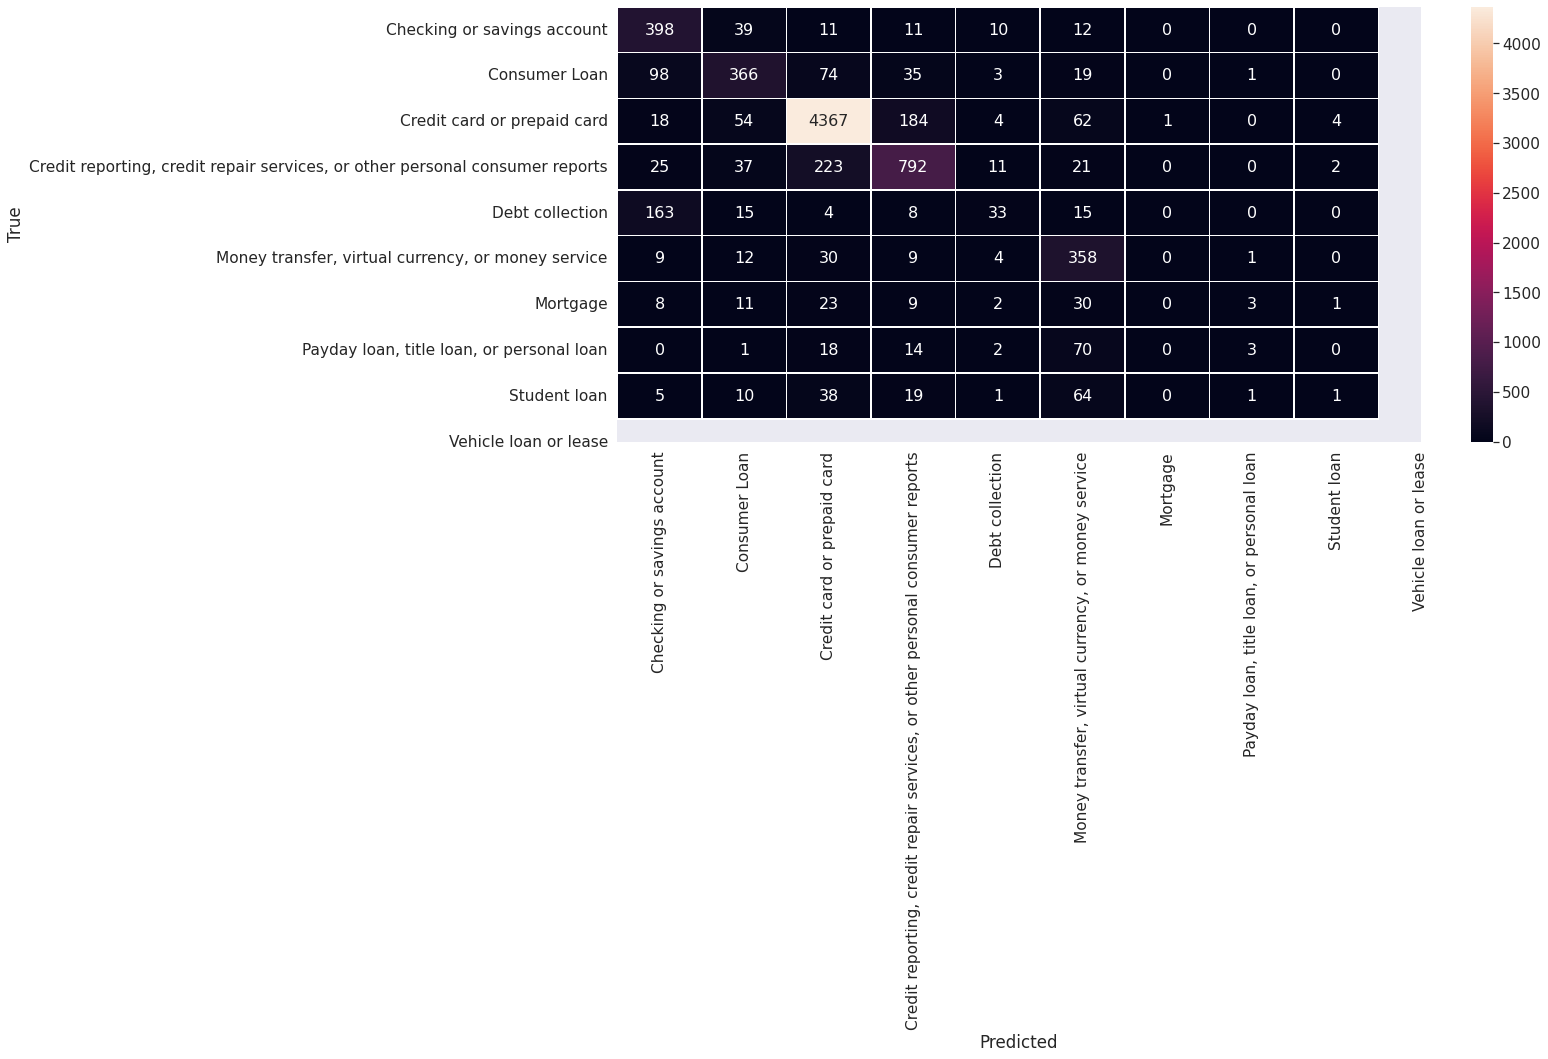

In [ ]:
cm = confusion_matrix(expected_classes, predicted_classes)
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d',linewidths=0.5, xticklabels=labels, yticklabels=labels) 
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()